#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini projects (Predicting neural activity)

The objective of the mini project is to:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
To: /home/jupyter/week 5/IT_data.h5
100%|██████████| 384M/384M [00:09<00:00, 42.5MB/s] 


'IT_data.h5'

### Load the data

In [3]:
### Utils
import h5py
import os

import matplotlib.pyplot as plt
import numpy as np


def load_it_data(path_to_data):
    """ Load IT data

    Args:
        path_to_data (str): Path to the data

    Returns:
        np.array (x6): Stimulus train/val/test; objects list train/val/test; spikes train/val
    """

    datafile = h5py.File(os.path.join(path_to_data,'IT_data.h5'), 'r')

    stimulus_train = datafile['stimulus_train'][()]
    spikes_train = datafile['spikes_train'][()]
    objects_train = datafile['object_train'][()]
    
    stimulus_val = datafile['stimulus_val'][()]
    spikes_val = datafile['spikes_val'][()]
    objects_val = datafile['object_val'][()]
    
    stimulus_test = datafile['stimulus_test'][()]
    objects_test = datafile['object_test'][()]

    ### Decode back object type to latin
    objects_train = [obj_tmp for obj_tmp in objects_train] #.decode("latin-1")
    objects_val = [obj_tmp for obj_tmp in objects_val]
    objects_test = [obj_tmp for obj_tmp in objects_test]

    return stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val


def visualize_img(stimulus,objects,stim_idx):
    """Visualize image given the stimulus and corresponding index and the object name.

    Args:
        stimulus (array of float): Stimulus containing all the images
        objects (list of str): Object list containing all the names
        stim_idx (int): Index of the stimulus to plot
    """    
    normalize_mean=[0.485, 0.456, 0.406]
    normalize_std=[0.229, 0.224, 0.225]

    img_tmp = np.transpose(stimulus[stim_idx],[1,2,0])

    ### Go back from normalization
    img_tmp = (img_tmp*normalize_std + normalize_mean) * 255

    plt.figure()
    plt.imshow(img_tmp.astype(np.uint8),cmap='gray')
    plt.title(str(objects[stim_idx]))
    plt.show()
    return


In [4]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [5]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


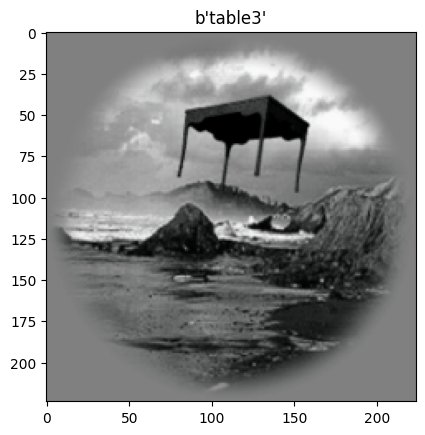

In [6]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

(2592, 168)

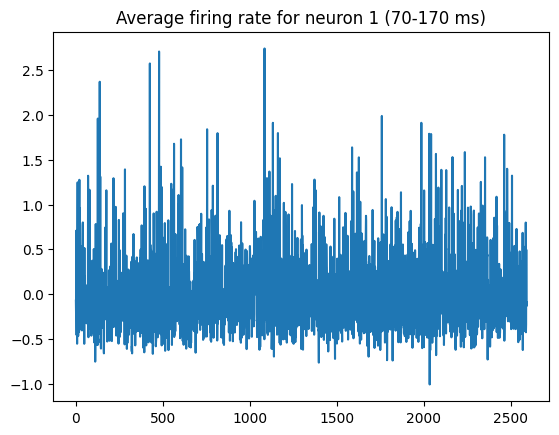

In [7]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,2])
spikes_train.shape

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [8]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
#for nn à voir
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten


import torch
import torch.nn as nn
import torch.optim as optim


In [9]:
#prepare x_train and x_test
X_train = stimulus_train.reshape(2592, 3*224*224) 
y_train = spikes_train
X_test = stimulus_val.reshape(288, 3*224*224)
y_test = spikes_val

In [10]:
X_train.shape
X_train2 =np.reshape(X_train, (2592, 3, 224, 224))
X_train2.shape
X_test2 = np.reshape(X_test, (288, 3, 224, 224))

# ALGOS

In [11]:
# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train2)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test2)
y_test_tensor = torch.tensor(y_test)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


### Model definitions

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Input dimension
input_channels = 3  # RGB channels
input_size = 224     # Image size (224x224)
input_samples_train = 2592  # Number of training input samples
input_samples_test = 288   # Number of testing input samples

# Output dimension
output_size = 168    # Number of output classes (neural activity)

# Define the basic Shallow CNN model
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 112 * 112, 512)
        self.fc2 = nn.Linear(512, 168)  # Output dimension for regression

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 112 * 112)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 168)
    
    
#tanh instead of relu, best model
class ShallowCNN2(nn.Module):
    def __init__(self):
        super(ShallowCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 112 * 112, 512)
        self.fc2 = nn.Linear(512, 168)  # Output dimension for regression

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 112 * 112)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 168)

#add one convolutional layer   
class ShallowCNN3(nn.Module):
    def __init__(self):
        super(ShallowCNN3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 168)  # Output dimension for regression

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool1(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 168)
    
    
# more complex and "brain-inspired" network
class ShallowCNN4(nn.Module):
    def __init__(self):
        super(ShallowCNN4, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 168)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x) #sparsity rule! 
        x = self.fc2(x)
        return x.view(-1, 168)


# Create the Shallow CNN model instance
model = ShallowCNN2()

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.005) #0.1411 for 0.001
optimizer = optim.SGD(model.parameters(), lr=0.05)





## Model evaluation

In [13]:
# Training loop
num_epochs = 10  # Set the number of epochs for training
y_test_pred = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
    #prev_loss = 1
    # Evaluation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            outputs = model(inputs)
            #predicted_labels = outputs # Get the predicted labels with highest activation
            #y_test_pred.extend(predicted_labels.tolist())  # Append predicted labels to the list

            loss = criterion(outputs, targets)
            total_loss += loss.item()
        avg_loss = total_loss / len(test_dataloader)
        #if (prev_loss-avg_loss <= 0.0001)
            #break
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/10], Average Loss: 0.1299
Epoch [2/10], Average Loss: 0.1258
Epoch [3/10], Average Loss: 0.1230
Epoch [4/10], Average Loss: 0.1204
Epoch [5/10], Average Loss: 0.1203
Epoch [6/10], Average Loss: 0.1187
Epoch [7/10], Average Loss: 0.1172
Epoch [8/10], Average Loss: 0.1184
Epoch [9/10], Average Loss: 0.1163
Epoch [10/10], Average Loss: 0.1156


In [14]:
# Training loop of BEST MODEL
num_epochs = 10  # Set the number of epochs for training
y_test_pred = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
    #prev_loss = 1
    # Evaluation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            outputs = model(inputs)
            #predicted_labels = outputs # Get the predicted labels with highest activation
            #y_test_pred.extend(predicted_labels.tolist())  # Append predicted labels to the list

            loss = criterion(outputs, targets)
            total_loss += loss.item()
        avg_loss = total_loss / len(test_dataloader)
        #if (prev_loss-avg_loss <= 0.0001)
            #break
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/10], Average Loss: 0.1153
Epoch [2/10], Average Loss: 0.1152
Epoch [3/10], Average Loss: 0.1161
Epoch [4/10], Average Loss: 0.1148
Epoch [5/10], Average Loss: 0.1144
Epoch [6/10], Average Loss: 0.1171
Epoch [7/10], Average Loss: 0.1132
Epoch [8/10], Average Loss: 0.1118
Epoch [9/10], Average Loss: 0.1152
Epoch [10/10], Average Loss: 0.1138


### Parameters to optimize

- ShallowCNN
    - SGD:
        - lr = 0.001 => 0.1278
        - lr = 0.005 => 0.1256
        - lr = 0.01  => 0.1229
        - lr = 0.03  => 0.1247
        - *lr = 0.05 => 0.1170*
            - tanh instead of relu => 0.116 /0.1152 in previous iteration
        - lr = 0.06 => 0.1186
        - lr = 0.07 => 0.1277
        - lr = 0.1  => 0.12
        
     - Adam:
         - lr = 0.01 => 0.3-0.4 
         - lr = 0.001 => 0.1411
         
- ShallowCNN3
    - SGD:
        - lr = 0.05 => 0.1152
        
- ShallowCCN4 => mimicking of neural pathway (sparsity with dropout, smaller kernel size (like the smaller receptive field of neurons)
    - SGD:
        - lr = 0.05 => 0.1244 => too complex, overfit probably


In [15]:
#y_test_prediction with the CNN
y_test_pred = []
for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            outputs = model(inputs)
            predicted_labels = outputs # Get the predicted labels with highest activation
            y_test_pred.extend(predicted_labels.tolist())  # Append predicted labels to the list


### Correlation and explained variance

In [16]:
from sklearn import metrics as ms
from scipy.stats import pearsonr

y_test_pred = np.array(y_test_pred)

correlation = []
var = []

for i in range(y_test.shape[1]) : #each neuron
    correlation.append(pearsonr(y_test_pred[:,i],y_test[:,i])[0])
    var.append(ms.explained_variance_score(y_test[:,i],y_test_pred[:,i]))

In [17]:
print("mean correlation = ", np.mean(correlation), " and mean explained variance  = ", np.mean(var))

mean correlation =  0.4167801825377025  and mean explained variance  =  0.17549669266048679


#### Plot of performance across all neurons

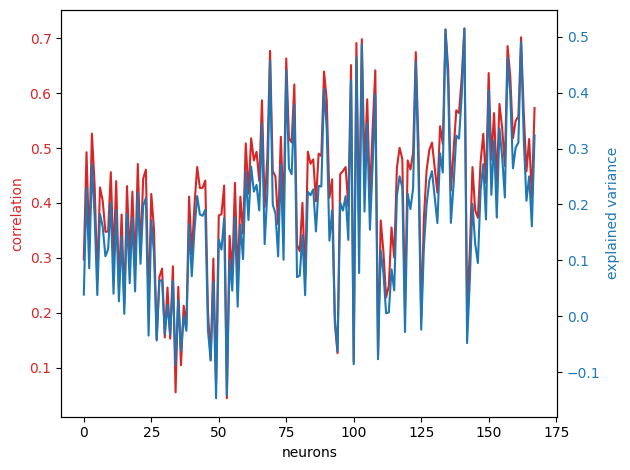

In [18]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('neurons')
ax1.set_ylabel('correlation', color=color)
ax1.plot(correlation, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('explained variance', color=color)  # we already handled the x-label with ax1
ax2.plot(var, color =color )
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.title("Best NN Model evaluation across neurons")
plt.savefig("best_nn_model_eval", bbox_inches='tight')
plt.show()

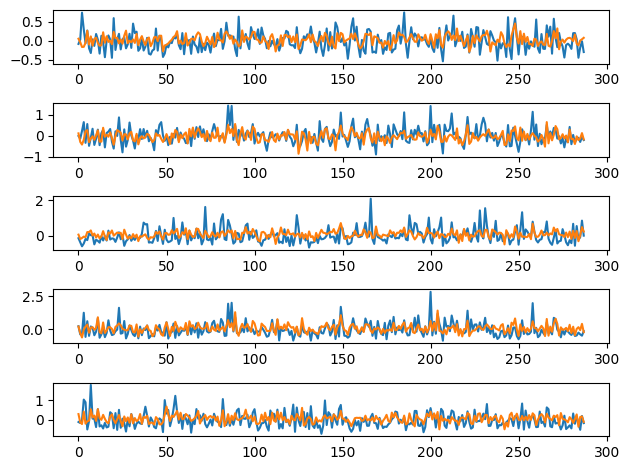

In [19]:
N = 5
fig, axs = plt.subplots(N, 1)

for n in range(N) : 
    axs[n].plot(y_test[:,n])
    axs[n].plot(y_test_pred[:,n])
    
fig.tight_layout()
#plt.title("predicted vs real neuronal activity for subset if neurons") 
plt.savefig("pred_vs_real_neuronal_act", bbox_inches='tight')
plt.show()